# Disentangled Representational Learning of Single Lead Electrocardiogram Signals using  Variational Autoencoder

### Imports

In [136]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import glob
import ipywidgets as widgets

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from src.metrics.disentanglement import Disentanglement
from src.utils.helper import Helper
from src.utils.visualizations import Visualizations

### Path Selection

In [137]:
val = widgets.Dropdown(
    options=sorted(glob.glob('../results/*')),
    description='Base path:',
    disabled=False,
)

In [138]:
val

Dropdown(description='Base path:', options=('../results/2024-01-22_16-47-45', '../results/2024-01-22_20-56-30'…

In [139]:
path_base = val.value + '/'
path_embedding = path_base + 'evaluation/embedding/'
path_personalization = path_base + 'evaluation/personalization/'
path_training = path_base + 'training/'

### 0. General

In [140]:
params = Helper.load_yaml_file(path_base + 'params.json')

In [141]:
params['coefficients']

{'alpha': 1.0, 'beta': 32.0, 'gamma': 1.0}

In [142]:
train_progress = pd.read_csv(path_training + 'training_progress.csv')

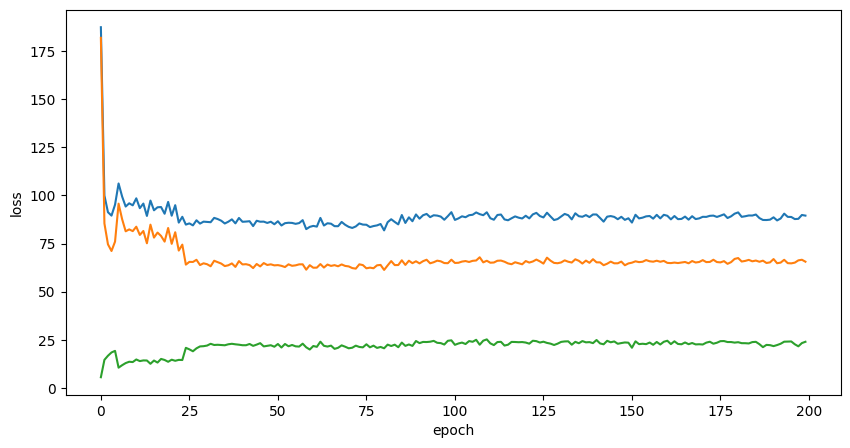

In [143]:
Visualizations.plot_trainings_process(train_progress[0:250], ['loss', 'recon', 'kl_loss'])

### 1. Disentanglement

In [144]:
df, ld = Helper.load_embedding(path_embedding, 'synth', 'train')

In [145]:
pca_data = Helper.embedding(df.iloc[:, 0:ld], df.iloc[:, ld:])

/mnt/sdb/home/ml/Desktop/VECG/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


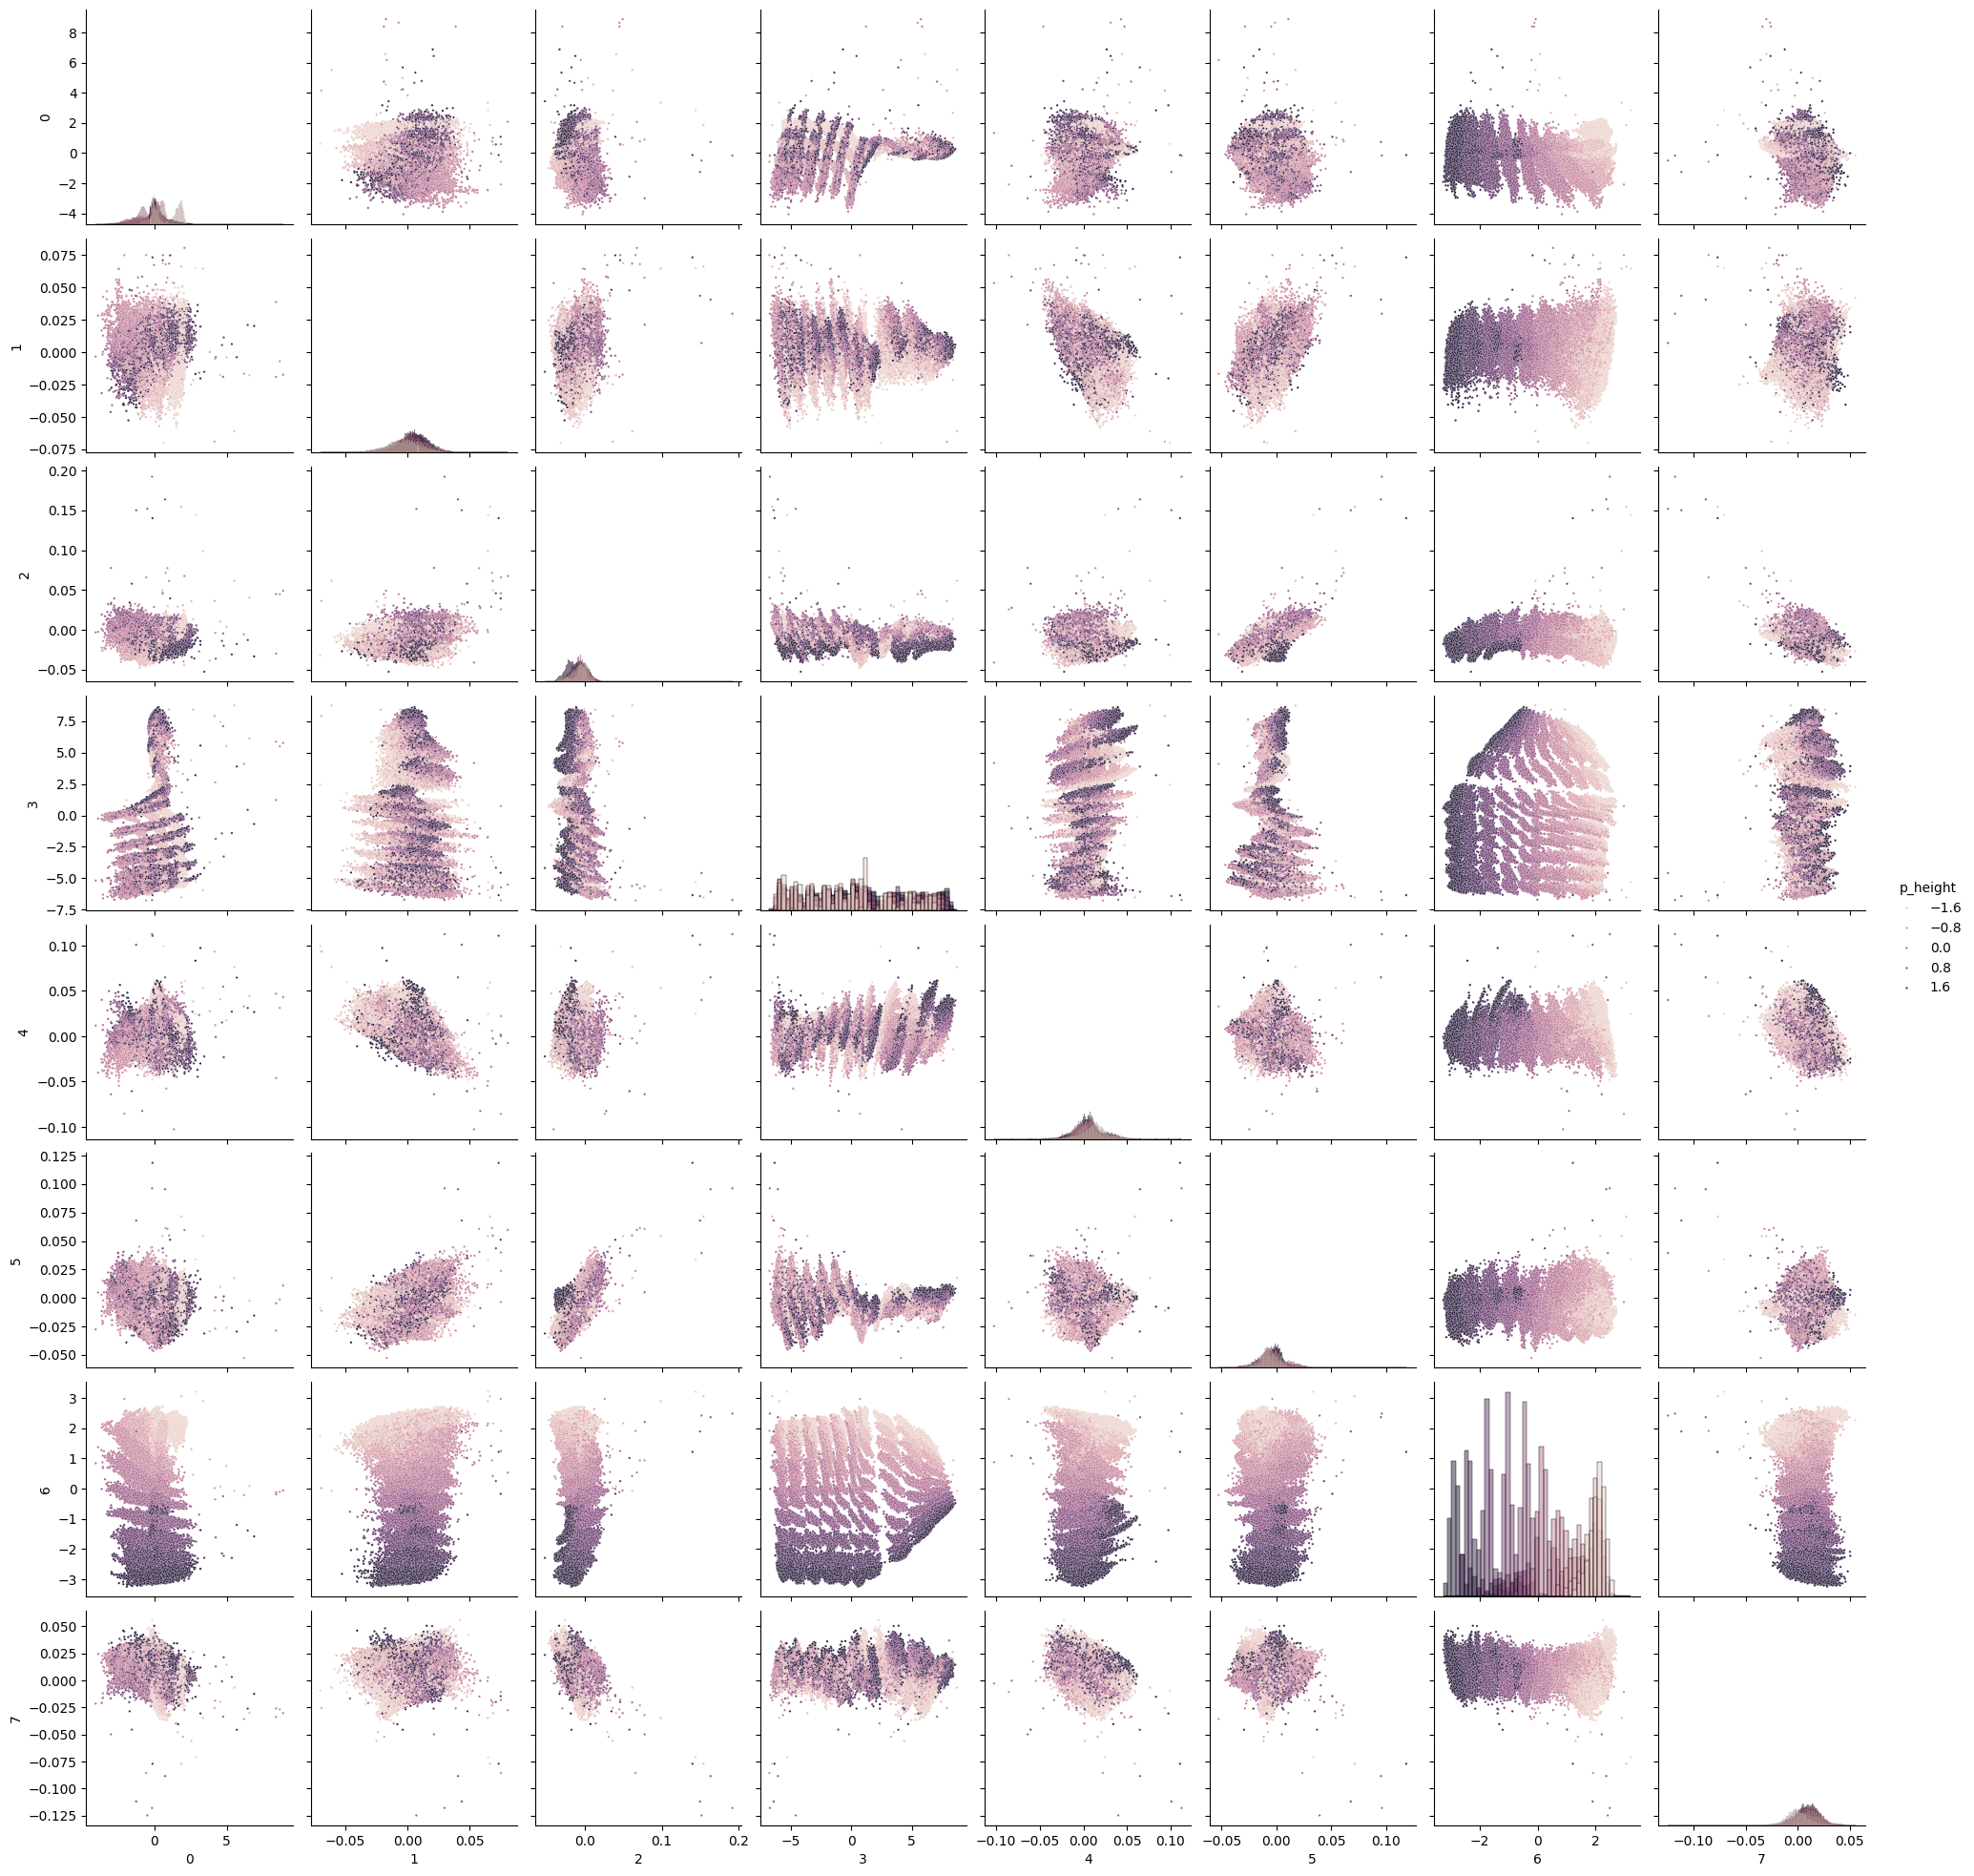

In [146]:
ax = sns.pairplot(df[list(range(0, ld)) + ['p_height']], hue="p_height", diag_kind="hist", plot_kws={"s": 3})

/mnt/sdb/home/ml/Desktop/VECG/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


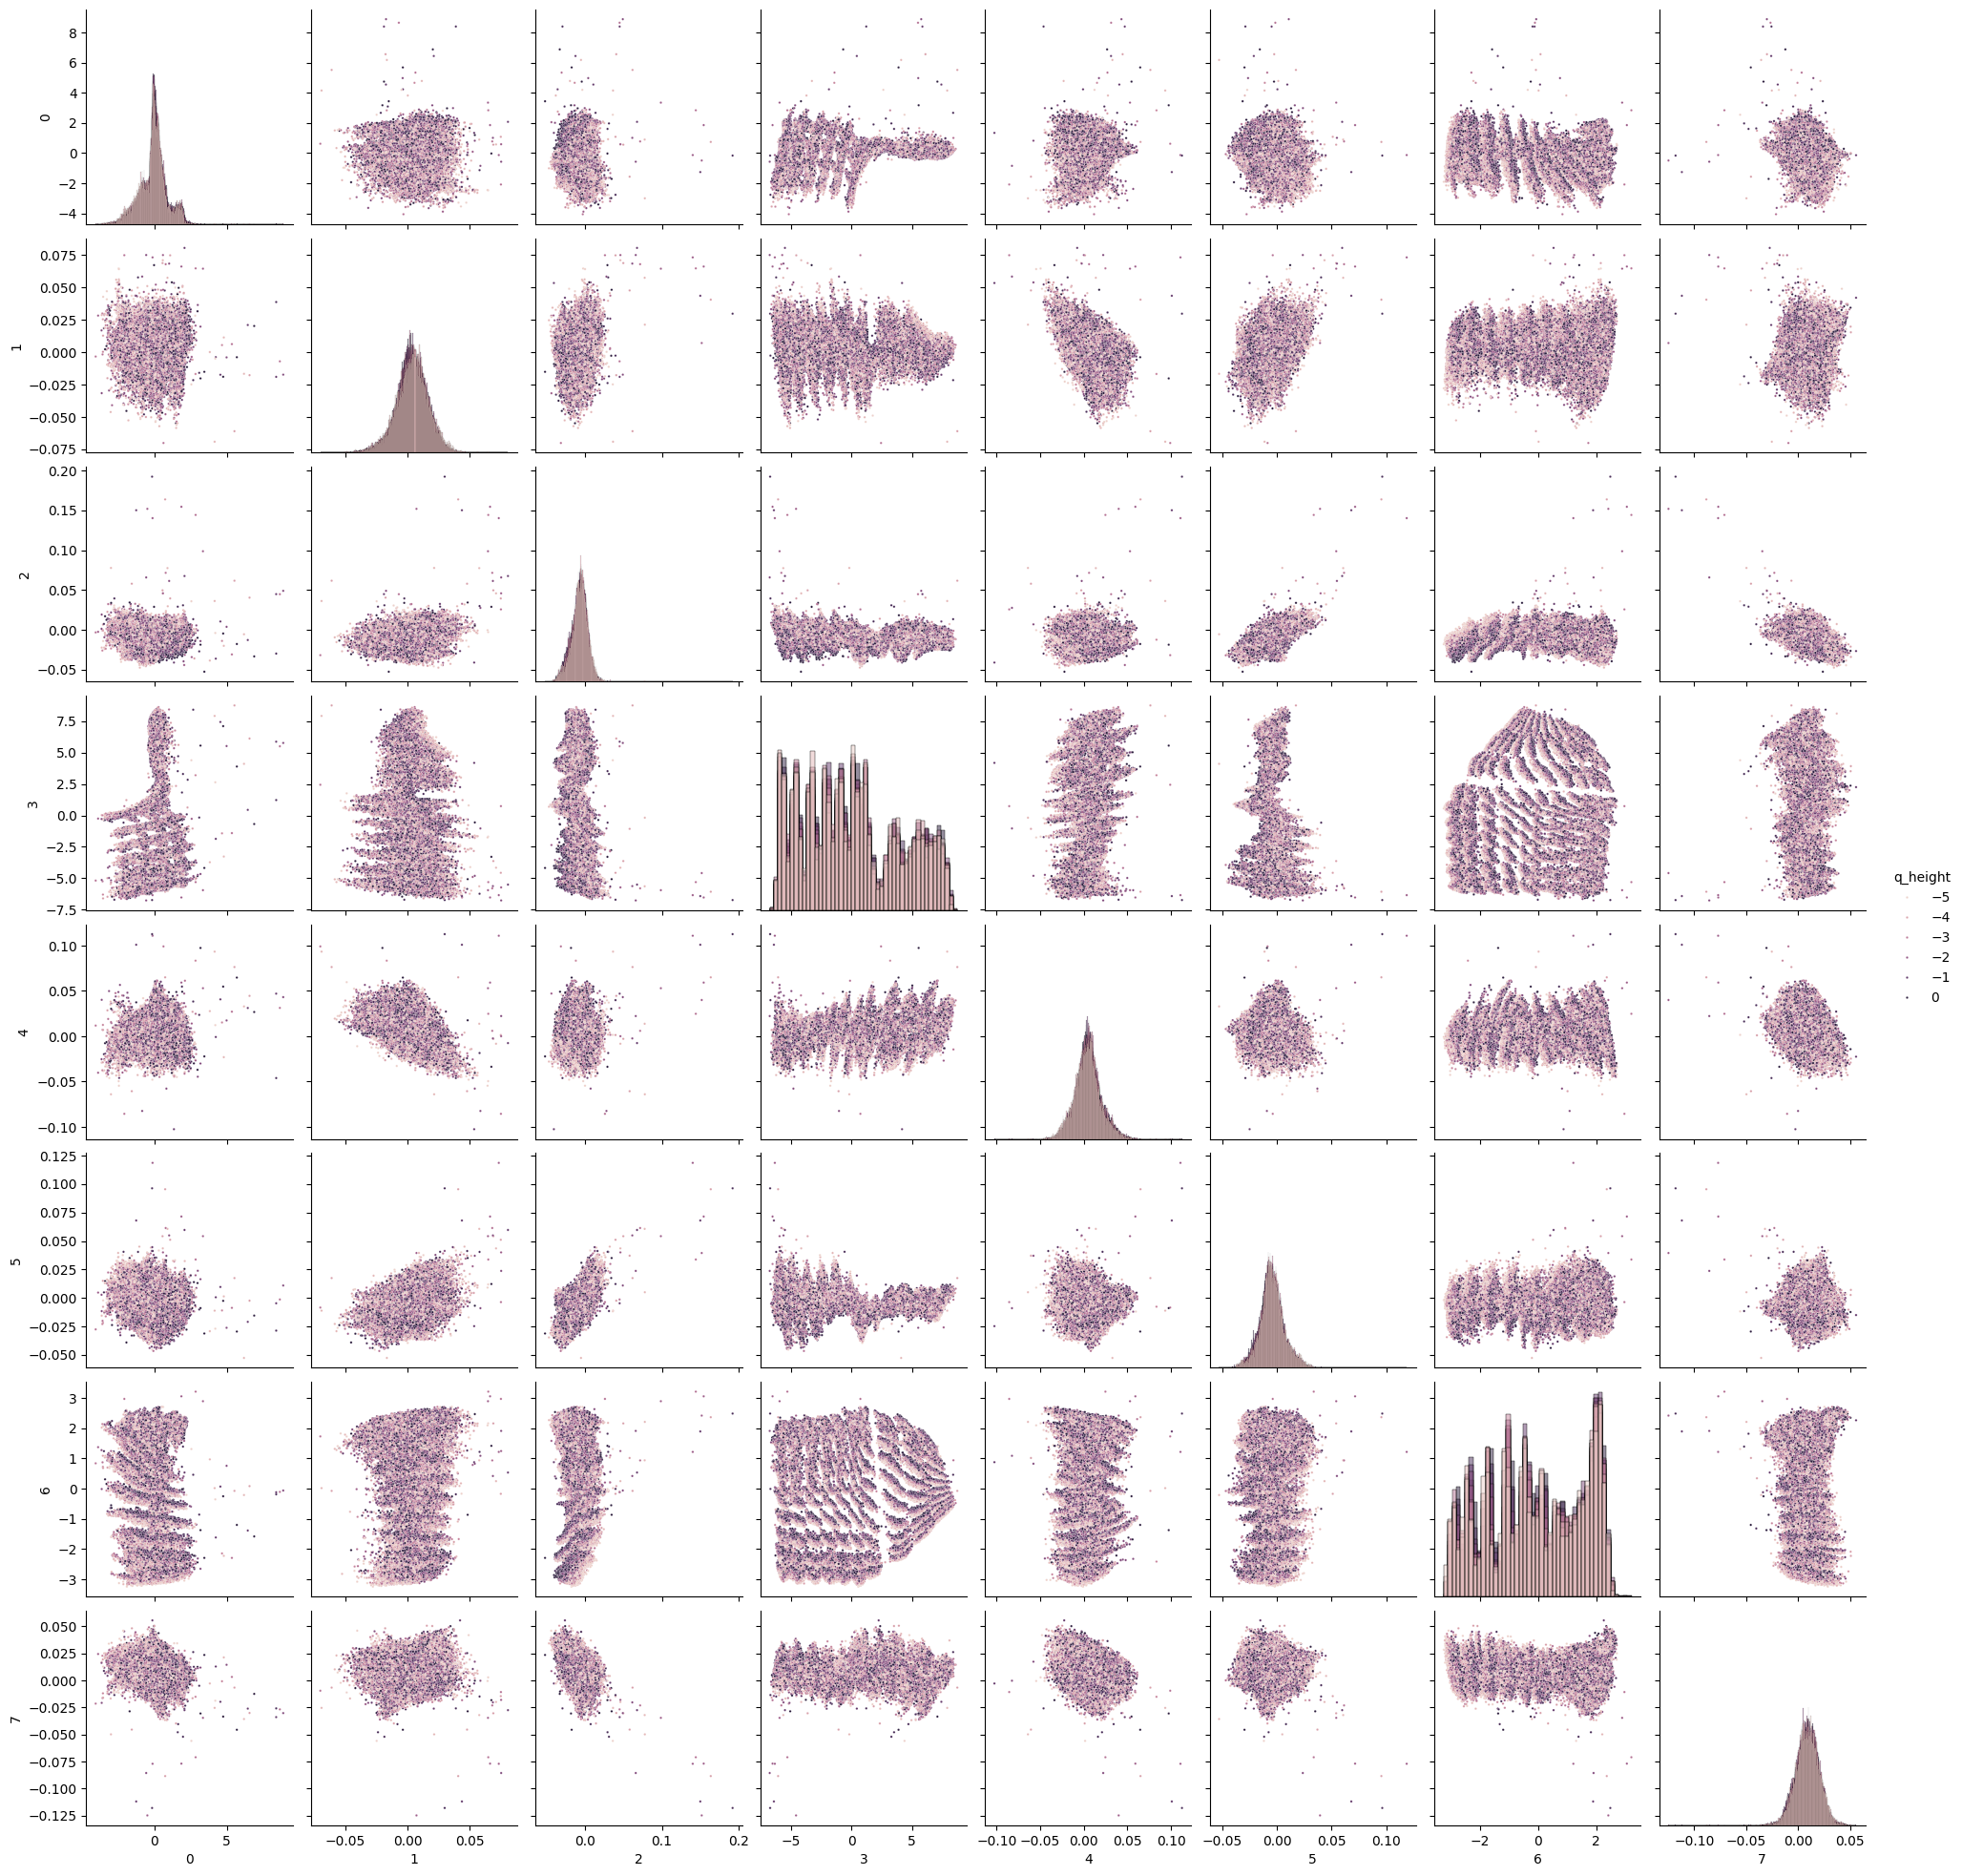

In [147]:
ax = sns.pairplot(df[list(range(0, ld)) + ['q_height']], hue="q_height", diag_kind="hist", plot_kws={"s": 3})

In [148]:
mus_train = np.array(df.iloc[:, :ld])
ys_train = np.array(df.iloc[:, ld:])

In [149]:
Disentanglement.compute_mig(mus_train, ys_train)

{'discrete_mig': 0.39570572381901453}

In [150]:
import ipywidgets as widgets

In [151]:
model = tf.keras.models.load_model(path_base + 'model/')

/mnt/sdb/home/ml/Desktop/VECG/venv/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [152]:
def reconstruct(dim, x):
    embedding = np.mean(df.iloc[:,:ld], axis=0)
    embedding[dim] = x
    embedding = np.reshape(embedding, (1, ld))
    decoded = np.reshape(model.decode(embedding), 500)
    plt.figure(figsize=(15,5))
    plt.plot(decoded)

In [153]:
widgets.interact(reconstruct, dim=range(0,ld), x=(-10.0, 10.0, .5))

interactive(children=(Dropdown(description='dim', options=(0, 1, 2, 3, 4, 5, 6, 7), value=0), FloatSlider(valu…

<function __main__.reconstruct(dim, x)>

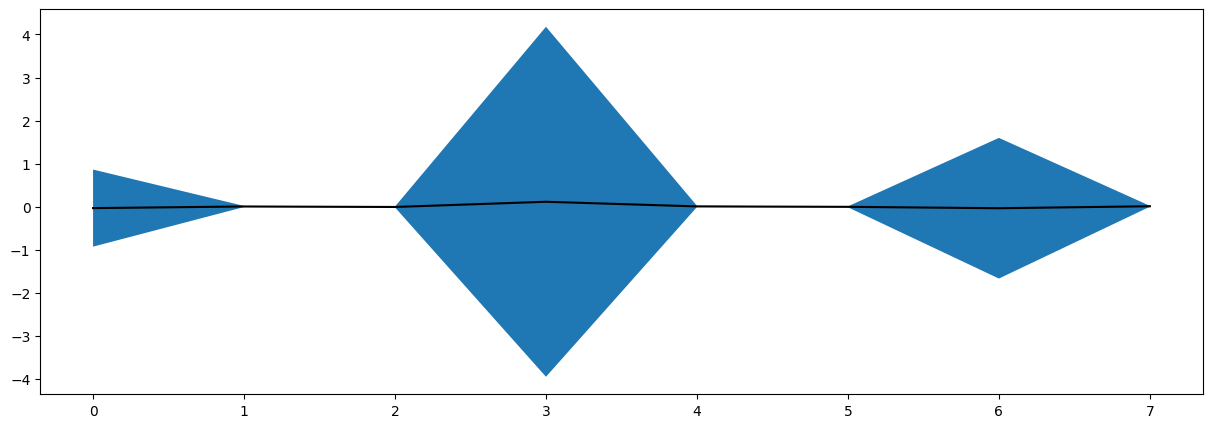

In [156]:
mu = np.mean(df.iloc[:,:ld], axis=0)
std = np.std(df.iloc[:,:ld], axis=0)
M = np.zeros(shape=(5000, ld))
M[:, 0] = np.linspace(mu[0] - 3*std[0], mu[0] + 3*std[0], M.shape[0])
M[:, 1] = mu[1]
plt.figure(figsize=(15, 5))
plt.plot(range(0, len(mu)), mu, 'k-')
plt.fill_between(range(0, len(mu)), mu - std, mu + std)

### 2. Anomaly Detection

In [157]:
df, ld = Helper.load_embedding(path_embedding, 'zheng', 'train')

In [158]:
a = ['SB', 'SR', 'AFIB', 'ST', 'AF', 'SI', 'SVT', 'AT', 'AVNRT', 'AVRT', 'SAAWR', 'SA']

In [159]:
for k in range(0, len(a)):
    df.rhythm = df.rhythm.replace(float(k), a[k])

In [160]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0:ld], df['rhythm'], test_size=0.2, random_state=42)

In [161]:
mus_train = np.array(df.iloc[:, :ld])
ys_train = np.array(df.iloc[:, ld:])

In [742]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

parameters = {
    'colsample_bytree': [0.7],
    'learning_rate': [0.05],
    'max_depth': [4, 5, 6, 7],
    'n_estimators': [180],
}

estimator = XGBClassifier(
    nthread=8,
    max_depth=5,
    seed=42
)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    #scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=4
)

estimator.fit(X_train, y_train.astype(int))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, nthread=8,
              num_parallel_tree=None, ...)

In [743]:
from sklearn.metrics import accuracy_score

In [744]:
predictions

array([1, 1, 0, ..., 4, 4, 1])

In [745]:
np.array(y_test.astype(int)) - predictions

array([ 0,  0,  6, ...,  0, -4,  0])

In [746]:
y_test

10560    1
5636     1
9191     6
2515     4
958      1
        ..
7932     1
1482     1
3544     4
2846     0
2802     1
Name: rhythm, Length: 2119, dtype: object

In [163]:
predictions = estimator.predict(X_test)
accuracy = accuracy_score(y_test.astype(int), predictions)
print("Accuracy: %.2f%%" % (accuracy*100.0))

cm = confusion_matrix(y_test.astype(int), predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'PAC', 'PVC'])
disp.plot()
plt.show()

NameError: name 'estimator' is not defined

In [556]:
#tsne_data = Helper.embedding(df.iloc[:, 0:ld], df.iloc[:, ld:], TSNE(n_components=2))

In [118]:
pca_data = Helper.embedding(df.iloc[:, 0:ld], df.iloc[:, ld:])

/mnt/sdb/home/ml/Desktop/VECG/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


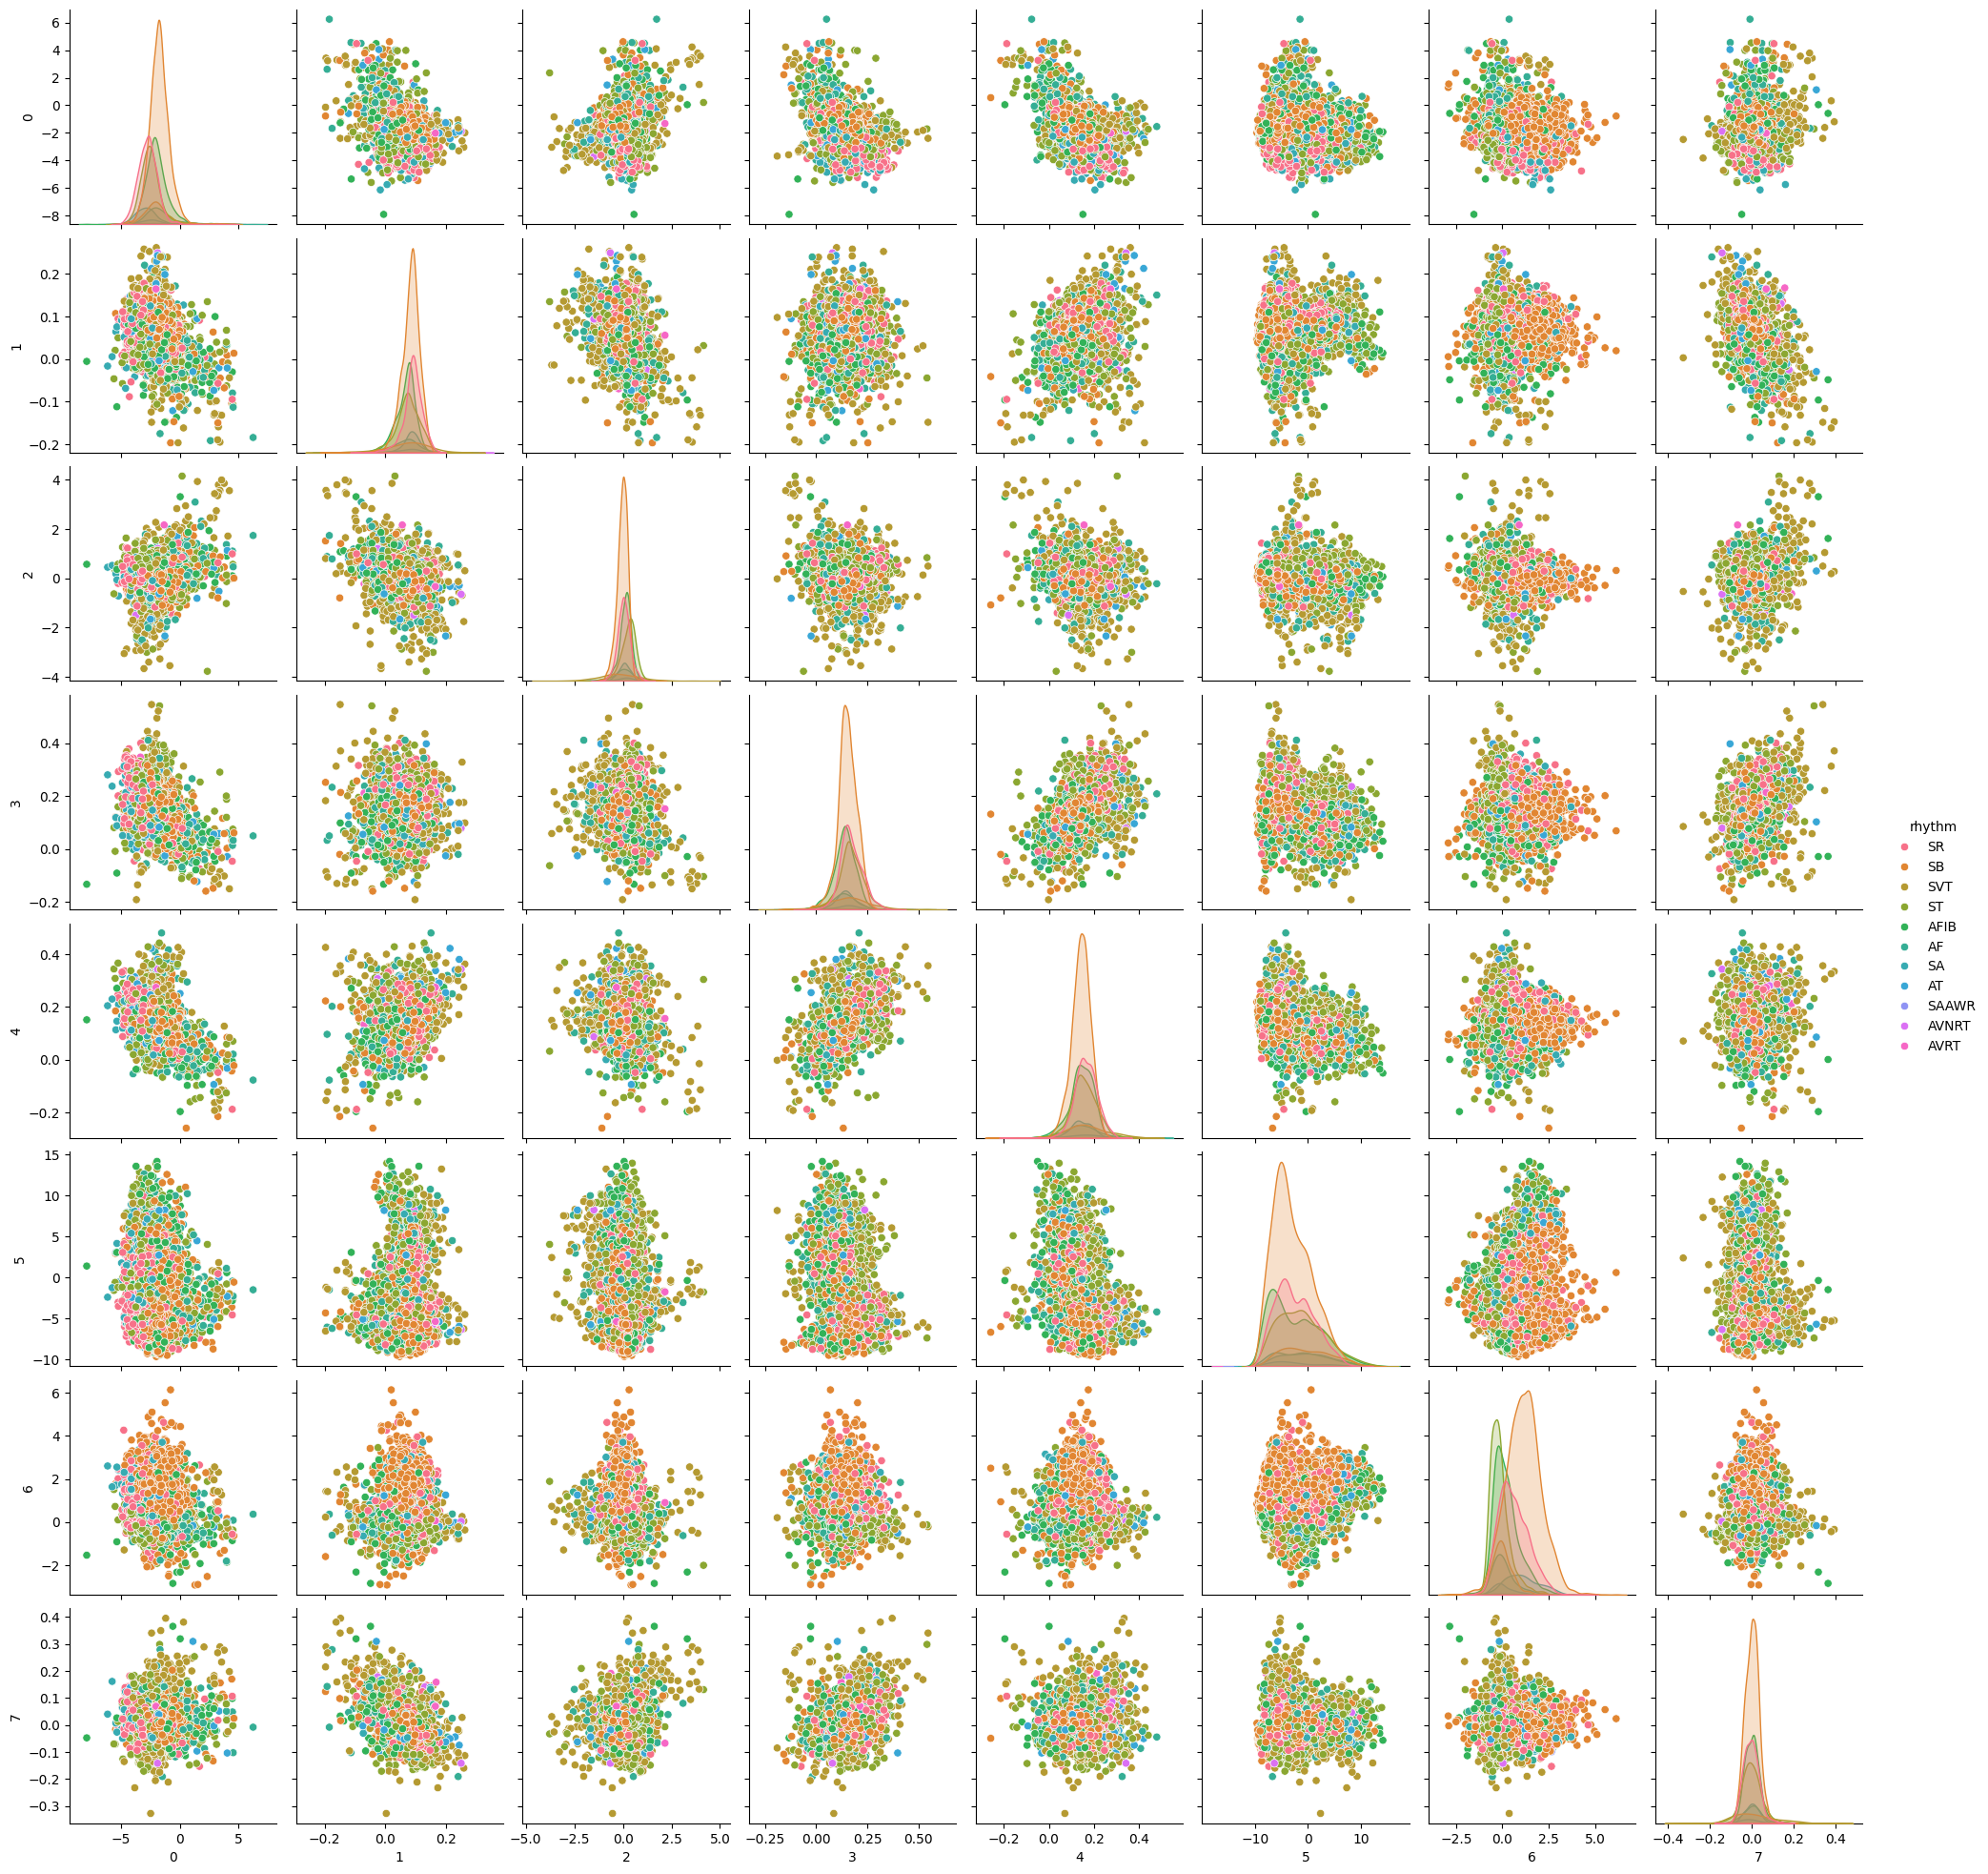

In [91]:
sns.pairplot(df[list(range(0, ld)) + ['rhythm']], hue="rhythm")

In [164]:
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [165]:
predictions = neigh.predict(X_test)

<Figure size 1500x1500 with 0 Axes>

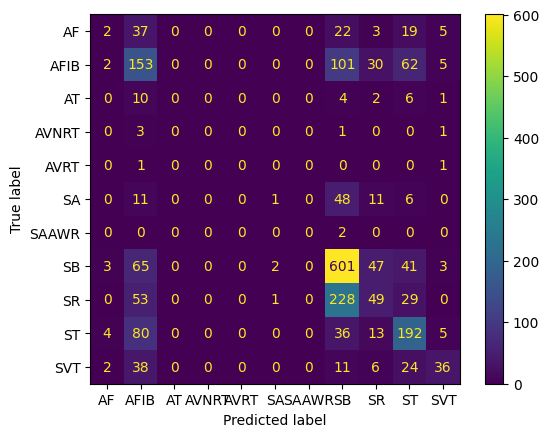

In [166]:
cm = confusion_matrix(y_test, predictions, labels=neigh.classes_)
plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot()
plt.show()

In [167]:
np.trace(cm) / np.sum(cm)

0.487966021708353

### 3. Personalization

In [182]:
df, ld = Helper.load_embedding(path_personalization, 'icentia11k', '6998')

In [183]:
df.beat = df.beat.replace(0.0, 'Normal').replace(1.0, 'Unclassified').replace(2.0, 'PAC').replace(3.0, 'PVC')

In [184]:
#df.beat = df.beat.replace(0.0, 0).replace(1.0, 4).replace(2.0, 1).replace(3.0, 2)

In [185]:
tsne_data = Helper.embedding(df.iloc[:, 0:ld], df.iloc[:, ld:])

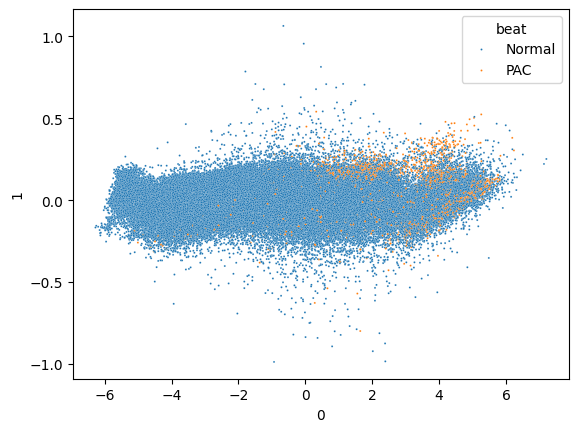

In [186]:
ax = sns.scatterplot(data=tsne_data[df.beat != 'Unclassified'], x=0, y=1, hue="beat", s=2)

In [187]:
X_train, X_test, y_train, y_test = train_test_split(
    df[df.beat != 'Unclassified'].iloc[:, 0:ld],
    df[df.beat != 'Unclassified']['beat'],
    test_size=0.2,
    random_state=42,
)

In [200]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(np.array(X_train), y_train)
predictions = neigh.predict(X_test)

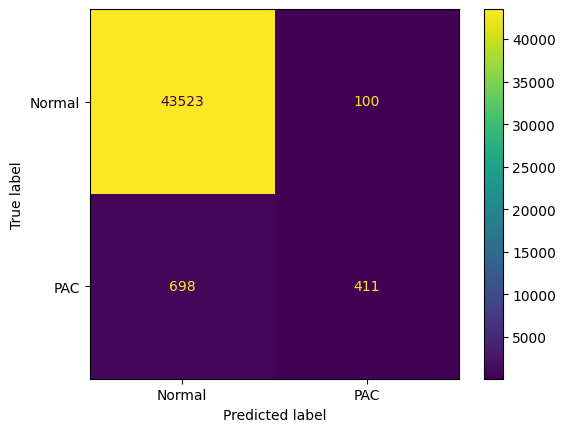

In [201]:
cm = confusion_matrix(y_test, predictions, labels=neigh.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot()
plt.show()

In [202]:
np.trace(cm) / np.sum(cm)

0.9821604220692122

In [203]:
cm

array([[43523,   100],
       [  698,   411]])